In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
import hyperopt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import lightgbm as lgbm
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict,ShuffleSplit
from imblearn.pipeline import Pipeline
import os
import numpy as np
import matplotlib.pyplot as plt
NPSEED = 1337
np.random.seed(NPSEED)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

,sex_1,sex_2,admitAge,admitCategoryCode_1,admitCategoryCode_2,entryCode_1,entryCode_2,entryCode_3,entryCode_4,admitByAmbulanceCode_1,...,raDrugAlcoholAbuse,raObesity,raStroke,raMentalHealth,raHepatic,raAsthma,raRheumatoid,raHIV,raPneumonia,riskTotal
1,1,0,90.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1,0,81.0,1,0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,1,0,72.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
7,1,0,88.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
9,1,0,89.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Data shape (11126, 103)


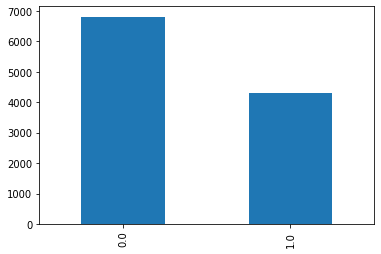

In [2]:
data = pickle.load(open('data/encoded_data.p','rb'))
display(data.head())
print(f"Data shape {data.shape}")
data['episodeDispositionCode'].value_counts().plot(kind='bar')
plt.show()
class_names =  ['Not continuing', 'Continuing Care']
features = list(data.keys())
features.remove('episodeDispositionCode')

In [3]:
data['episodeDispositionCode'].value_counts()

0.0    6807
1.0    4319
Name: episodeDispositionCode, dtype: int64

In [4]:
print('Features used:')
for feature in features:
    print(feature, end = ', ')

Features used:
sex_1, sex_2, admitAge, admitCategoryCode_1, admitCategoryCode_2, entryCode_1, entryCode_2, entryCode_3, entryCode_4, admitByAmbulanceCode_1, admitByAmbulanceCode_2, admitByAmbulanceCode_3, admitByAmbulanceCode_4, institutionZoneId_1, institutionZoneId_2, institutionZoneId_3, institutionZoneId_4, institutionZoneId_5, institutionZone_1, institutionZone_2, institutionZone_3, institutionZone_4, institutionZone_5, institutionTypeId_1, institutionTypeIdFrom_1, institutionTypeIdFrom_2, institutionTypeIdFrom_3, institutionTypeIdFrom_4, institutionTypeIdFrom_5, institutionTypeIdFrom_6, institutionTypeIdFrom_7, institutionTypeIdFrom_8, mainPatientService, mostRespDxCode_1, mostRespDxCode_2, mostRespDxCode_3, mostRespDxCode_4, mostRespDxCode_5, mostRespDxCode_6, mostRespDxCode_7, mostRespDxCode_8, mostRespDxCode_9, mostRespDxCode_10, mostRespDxCode_11, mostRespDxCode_12, mostRespDxCode_13, mostRespDxCode_14, mostRespDxCode_15, mostRespDxCode_16, mostRespDxCode_17, mostRespDxCode_1

In [19]:
X = data.drop('episodeDispositionCode', axis=1)
y = data['episodeDispositionCode']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify = y_train)
feat_names = list(X_train.keys())

In [24]:
# No need: data is fairly balanced
#smt = ADASYN(random_state=0)
#X_train, y_train = smt.fit_resample(X_train, y_train)

# No need: we use tree based method
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)

In [31]:
#clf = lgbm.LGBMClassifier(is_unbalance=True).fit(X_train,y_train) #altalab search used to find best pipline
clf = lgbm.LGBMClassifier().fit(X_train,y_train) #altalab search used to find best pipline
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
y_val_pred = clf.predict(X_valid)
y_val_probs = clf.predict_proba(X_valid)[:,1]

In [35]:
print(clf.predict(X_test))

[1. 1. 0. ... 0. 1. 0.]


In [34]:
print(clf.predict_proba(X_test))

[[0.37604993 0.62395007]
 [0.49447817 0.50552183]
 [0.99448513 0.00551487]
 ...
 [0.80940375 0.19059625]
 [0.05434554 0.94565446]
 [0.97565033 0.02434967]]


In [36]:
print(clf.predict_proba(X_test)[:,0]+clf.predict_proba(X_test)[:,1])

[1. 1. 1. ... 1. 1. 1.]


In [32]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names =  ['Not continuing', 'Continuing Care']    
    df_cm = pd.DataFrame(cm, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},  fmt='d')
    plt.show()
    metrics = np.array( precision_recall_fscore_support(y_test, y_pred) )
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    display(df_cm)

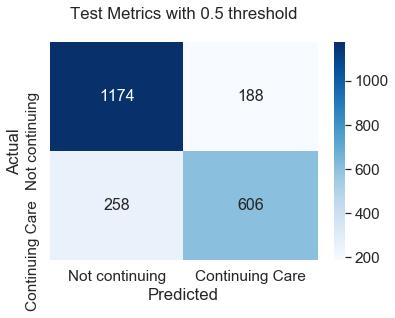

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.819832,0.763224
Recall,0.861968,0.701389
F,0.840372,0.731001
Support,1362.000000,864.000000


In [33]:
plt.title('Test Metrics with 0.5 threshold\n')
get_metrics(y_test, y_pred)

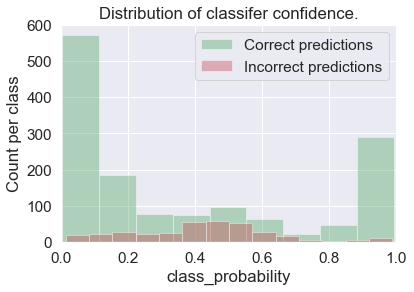

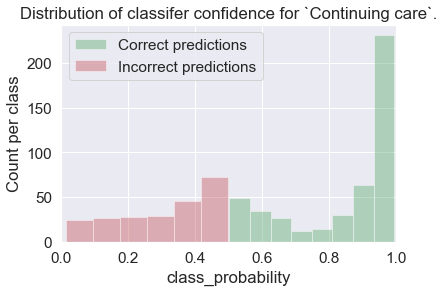

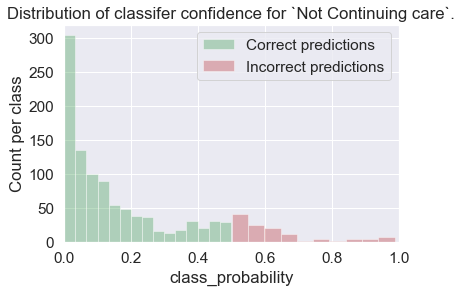

In [38]:
import seaborn as sns

pos_probas = y_val_probs[(y_valid == y_val_pred)]
neg_probas = y_val_probs[(y_valid != y_val_pred)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False, label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence.")
plt.legend()
plt.show()


mod_y_prob = 0.5
pos_probas = y_val_probs[(y_valid == y_val_pred) & (y_valid == 1)]
neg_probas = y_val_probs[(y_valid != y_val_pred)& (y_valid == 1)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False, label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence for `Continuing care`.")
plt.legend()
plt.show()
mod_y_prob = 0.5
pos_probas = y_val_probs[(y_valid == y_val_pred) & (y_valid == 0)]
neg_probas = y_val_probs[(y_valid != y_val_pred)& (y_valid == 0)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False,  label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence for `Not Continuing care`.")
plt.legend()
plt.show()

We see that for 

## Explaining the decision
We use a method called SHAP (SHapley Additive exPlanations). 
This plot is made of all the points in the validation data. It demonstrates the following information:
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis. 

The explanations of why the model performed the way it did on the test set is as follows.

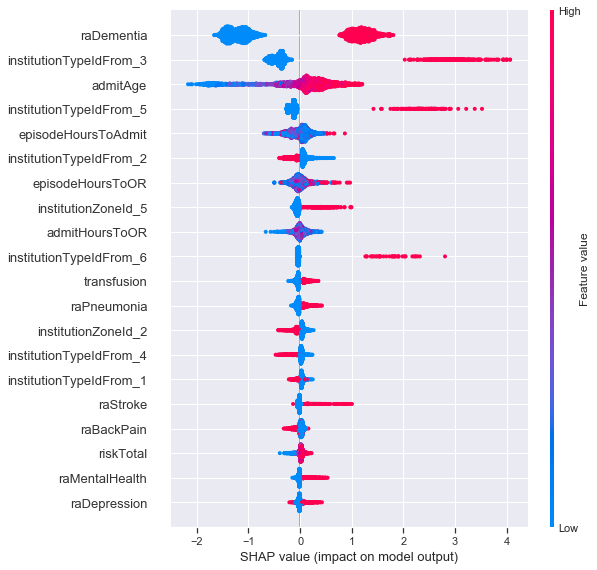

In [39]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(pd.DataFrame(X_test, columns = feat_names ))
shap.summary_plot(shap_values[1], pd.DataFrame(X_test, columns = feat_names ))

- From the SHAP plot above, we can see that the most siginficant effect comes from`raDementia`. Larger values of the feature pushes the model to categorize the patient more to Continuing care. 
- Similarly `admitAge` pushes the model to categorize the patient more to Continuing care. 
- `institutionTypeIdFrom` plays a major role as well. We see that if the patient is coming from `institutionTypeIdFrom` 3 or 5, the patient is likely to be predicted as needing contiuing care. 
- If the patient is coming from `institutionTypeIdFrom` 2,1,4, the patient is likely to be predicted as needing contiuing care. 
- There is a weak effect of `episodeHoursToAdmit`. This is not clear but large values seem to push the model to recommend continuing care. 
- A similar effect is, if `institutionZoneId` is 5 (North), the model is recommending continuing care.  


# Effect of removing uncertain predictions
To test if removing uncertain predictions can help improve the performance of the classifier, we select two thresholds (`th1` and `th2`) that sweep across the range of probability values of the classifer and pick the ones that maximizes the F score. Anything with a probability between the two thresholds will be considered as uncertain. 

In [40]:
y_pred_2 = 2*np.ones(y_valid.shape)
vmax = -999999
pmax = 0
for th1 in np.linspace(0,1,10):
    for th2 in np.linspace(0,1,10):
        y_pred_2 = 2*np.ones(y_valid.shape)
        y_pred_2[y_val_probs <= th1] = 0
        y_pred_2[y_val_probs >= th2] = 1
        if th1>th2:
            continue
        cm = confusion_matrix(y_valid, y_pred_2)
        tp = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        tn = cm[1][1]
        if cm.shape[1] == 3:
            class_names =  [ 'Not continuing care', 'Continuing Care', 'unknown']    
        else:
            class_names =  [ 'Continuing Care'] 
            
        if cm.shape[1] == 3:
            metrics = np.array( precision_recall_fscore_support(y_valid, y_pred_2) )
        else:
            metrics = np.array( precision_recall_fscore_support(y_valid, y_pred_2, average='binary') )
            
        
        df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
        
        df_cm.index.name = 'Class'
        df_cm.columns.name = 'Metrics'
        var_to_be_maximized =   np.mean(metrics[2])
        print(f"Not continuing care <{np.around(th1,2)}, uncertain [{np.around(th1,2)}, {np.around(th2,2)}]  and continuing care >{np.around(th2,2)}: F score = {np.around(var_to_be_maximized,2)}")
        if vmax < np.mean(var_to_be_maximized):
            vmax = np.mean(var_to_be_maximized)
            pmax = [th1, th2]
print(f'Best cutoffs F = {vmax} for Not continuing care <{np.around(pmax[0],2)}, uncertain [{np.around(pmax[0],2)},{np.around(pmax[1],2)}]  and continuing care >{np.around(pmax[1],2)}')

Not continuing care <0.0, uncertain [0.0, 0.0]  and continuing care >0.0: F score = 0.56
Not continuing care <0.0, uncertain [0.0, 0.11]  and continuing care >0.11: F score = 0.24
Not continuing care <0.0, uncertain [0.0, 0.22]  and continuing care >0.22: F score = 0.25
Not continuing care <0.0, uncertain [0.0, 0.33]  and continuing care >0.33: F score = 0.25
Not continuing care <0.0, uncertain [0.0, 0.44]  and continuing care >0.44: F score = 0.25
Not continuing care <0.0, uncertain [0.0, 0.56]  and continuing care >0.56: F score = 0.23
Not continuing care <0.0, uncertain [0.0, 0.67]  and continuing care >0.67: F score = 0.22
Not continuing care <0.0, uncertain [0.0, 0.78]  and continuing care >0.78: F score = 0.21
Not continuing care <0.0, uncertain [0.0, 0.89]  and continuing care >0.89: F score = 0.19
Not continuing care <0.0, uncertain [0.0, 1.0]  and continuing care >1.0: F score = 0.0
Not continuing care <0.11, uncertain [0.11, 0.11]  and continuing care >0.11: F score = 0.71
No

In [114]:
# Define costomized cost function

def Cost(y_pred, y_true, C_p, C_n):
    residual= (y_true - y_pred).astype("float")
    #print(residual[:20])
    #print(np.where(residual<0, C_n, C_p))
    cost = np.sum(np.where(residual<0, C_n, C_p))/len(y_valid.index)
    
    return cost

In [ ]:
# Define y_pred_2

                <----------Classifer output (probability)--------->
                 
|-------------------------------------*---------------------------------------------|
0   'Not continuing care'           theta        'Continuing care'                  1

In [121]:
# mimic what's been done but only use one decision thredhold
y_pred_3 = np.ones(y_valid.shape)
vmax = -999999
pmax = 0
c_p=1
c_n=0.8
for theta in np.linspace(0,1,10):

    y_pred_3 = np.ones(y_valid.shape)
    y_pred_3[y_val_probs <= theta] = 0
    #y_pred_3[y_val_probs >= theta] = 1
   
    # Confusion metrix for each thredhold
    cm = confusion_matrix(y_valid, y_pred_3)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
 

    class_names =  [ 'Continuing Care'] 
    metrics = np.array( precision_recall_fscore_support(y_valid, y_pred_3, average='binary') )
        
    print(metrics,'\n')        
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
        
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    var_to_be_maximized =   np.mean(metrics[2])
    print(f"Not continuing care <{np.around(theta,2)}, and continuing care >{np.around(theta,2)}: F score = {np.around(var_to_be_maximized,2)}")
    
    # Track the best decision thredhold
    if vmax < np.mean(var_to_be_maximized):
        vmax = np.mean(var_to_be_maximized)
        pmax = theta
print(f'Best cutoffs F = {vmax} for Not continuing care <{np.around(pmax,2)},  and continuing care >{np.around(pmax,2)}')




[0.38820224719101126 1.0 0.5592877377579927 None] 

Not continuing care <0.0, and continuing care >0.0: F score = 0.56
[0.5610169491525424 0.9580318379160637 0.7076429716729024 None] 

Not continuing care <0.11, and continuing care >0.11: F score = 0.71
[0.6523560209424084 0.9015918958031838 0.7569866342648846 None] 

Not continuing care <0.22, and continuing care >0.22: F score = 0.76
[0.6961722488038278 0.8422575976845152 0.762278978388998 None] 

Not continuing care <0.33, and continuing care >0.33: F score = 0.76
[0.7442196531791907 0.7452966714905933 0.7447577729573391 None] 

Not continuing care <0.44, and continuing care >0.44: F score = 0.74
[0.8396793587174348 0.6063675832127352 0.7042016806722688 None] 

Not continuing care <0.56, and continuing care >0.56: F score = 0.7
[0.922879177377892 0.5195369030390738 0.6648148148148149 None] 

Not continuing care <0.67, and continuing care >0.67: F score = 0.66
[0.9438202247191011 0.48625180897250364 0.6418338108882522 None] 

Not con

We see that including any prediction in undertain class reduces the performance of the algorithm.

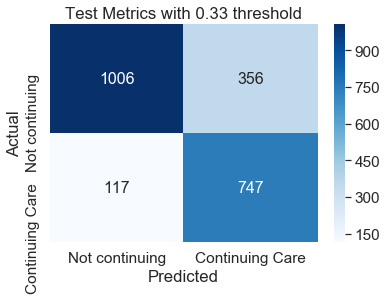

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.895815,0.677244
Recall,0.738620,0.864583
F,0.809658,0.759532
Support,1362.000000,864.000000


In [122]:
plt.title(f'Test Metrics with {np.around(pmax,2)} threshold')
get_metrics(y_test, y_prob>pmax)

We see that with further tuning performance of the classifier can be improved. 

## Test of reliability
To test if the classifer can maintain performance we create 10 random splits of the data in the training-test set and then repeat the process of evaluating the algorithm.

recall: 78.10% (1.01%)
precision: 79.09% (1.05%)
f1: 78.50% (1.02%)


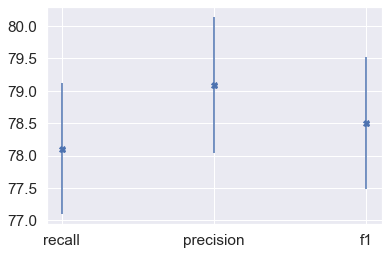

In [60]:
clf_not_tuned =  lgbm.LGBMClassifier() 
pipeline = Pipeline([('oversample', smt), ('scale', scaler), ('classifer', clf_not_tuned)])
metrics = []
means = []
standard_devs = []
for metric in [ 'recall','precision','f1']:
    kfold = ShuffleSplit(n_splits=10, test_size=0.20, random_state=NPSEED)
    all_fold_results = cross_val_score(pipeline, X, y, cv=kfold, scoring=f'{metric}_macro')
    m = all_fold_results.mean()*100.0
    s = all_fold_results.std()*100.0
    print(f"{metric}: %.2f%% (%.2f%%)" % ( m, s))
    metrics.append(metric)
    means.append(m)
    standard_devs.append(s)
plt.errorbar(metrics, means, standard_devs, linestyle='None', marker='X')
plt.show()